<a href="https://colab.research.google.com/github/a-forty-two/DataSetsForML/blob/master/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# No normalization
!ls

 sample_data  'Sample - Superstore (1).xls'


In [0]:
import warnings # only if time is left-> supress warning 
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm 
warnings.filterwarnings("ignore") # for production


In [0]:
df = pd.read_excel("Sample - Superstore (1).xls")
data = df.loc[df['Category']=='Furniture'] # row filtering by name, could be by index also using iloc and col no.

In [7]:
data['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [8]:
data['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

In [15]:
#data.info()
# MISSING values are not just null, but if there are factual missing data! dates missing!
# some days where no order was placed?
# Multiple orders could be placed on same date!!
# Just for clarity, group by order date
data_grouped = data.groupby('Order Date') # SQL operations -> GROUPBY, SUM, MUL, JOIN
data_grouped = data_grouped['Sales'].sum().reset_index() # TOTAL SALES, hence sum 
# average if average sales/per order
data_grouped.head() 

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [0]:
data_grouped.set_index('Order Date', inplace=True)
# its not just about nulls, what about dates not in record?
# COMBINE my data to month level

In [19]:
# for monthly sales, i should take average 
y = data_grouped['Sales'].resample('MS').mean()
y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: Sales, dtype: float64

In [22]:
y['2017':] # just a peek into our data

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

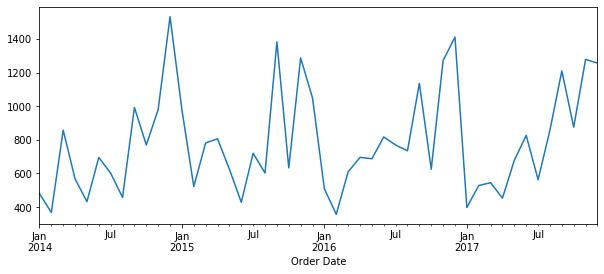

In [24]:
y.plot(figsize=(10,4))
plt.show()

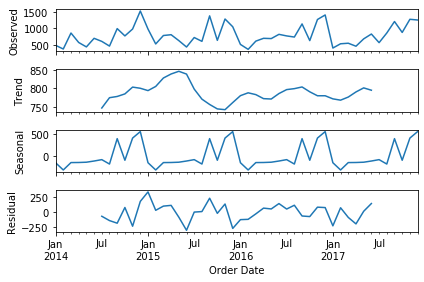

In [25]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive') # Original = Season + Trend + Residue
fig = decomposition.plot()
plt.show() # SARIMA -> Seasons 

In [32]:
# GRID SEARCH FOR EXHAUSTIVE MODELS 
# PLEASE NOTE: all models may not successfull -> often divide by 0 situation occur
# NOT ALL combinations of (p,d,q) and S,T,R may be successful.
# grid search will throw exception in such cases
# our code should be well exception handled when grid searching 

p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q)) # similar to ARIMA 
# here we will insert seasonal combinations into our pdq
seasons = 12 # because i have arranged data monthly, pattern cycle is 1 year-> hence season set to 1 year = 12 month
seasonal_pdq = [(x[0],x[1],x[2],seasons) for x in pdq]
# MERGE all combinations all PDQ with SEASONAL_PDQ
print('SARIMAX individual model= {} X {}'.format(pdq[2],seasonal_pdq[3]))


SARIMAX individual model= (0, 1, 0) X (0, 1, 1, 12)
Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
Freq: MS, Name: Sales, dtype: float64


In [33]:
# GRID search and compare Akaike IC for each model
for param in pdq:
  for param_s in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_s, enforce_stationarity=False, enforce_invertibility=False)
      predictions = model.fit()
      print('SARIMAX individual model= {} X {}. AIC= {}'.format(param,param_s, predictions.aic))
    except Exception as e:
      print(e)
      continue




SARIMAX individual model= (0, 0, 0) X (0, 0, 0, 12). AIC= 769.0817523205916
SARIMAX individual model= (0, 0, 0) X (0, 0, 1, 12). AIC= 1478.4829845115771
SARIMAX individual model= (0, 0, 0) X (0, 1, 0, 12). AIC= 477.71701309202774
maxlag should be < nobs
SARIMAX individual model= (0, 0, 0) X (1, 0, 0, 12). AIC= 497.2314433418337
SARIMAX individual model= (0, 0, 0) X (1, 0, 1, 12). AIC= 1284.058367274109
SARIMAX individual model= (0, 0, 0) X (1, 1, 0, 12). AIC= 318.0047199116341
maxlag should be < nobs
SARIMAX individual model= (0, 0, 1) X (0, 0, 0, 12). AIC= 720.9252270758101
SARIMAX individual model= (0, 0, 1) X (0, 0, 1, 12). AIC= 3151.7661575378966
SARIMAX individual model= (0, 0, 1) X (0, 1, 0, 12). AIC= 466.56074298091676
maxlag should be < nobs
SARIMAX individual model= (0, 0, 1) X (1, 0, 0, 12). AIC= 499.58288234908053
SARIMAX individual model= (0, 0, 1) X (1, 0, 1, 12). AIC= 354243.3332148463
SARIMAX individual model= (0, 0, 1) X (1, 1, 0, 12). AIC= 319.9884876946871
maxlag shou

In [0]:
model = sm.tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)

In [35]:
# USER PROVIDES me sales data-> furniture sales data-> PARAMETERS
# EVERYTHING ELSE THAT DEVELOPERS SET that can impact your MDOEL-> HYPERPARAMETER
# GRID search is extensively used for Hyperparameter search or tuning
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04
